# AI Lab Run
V1: New dataset, old model.   
A3: untrain model.   
A5: this time we change the traning target to predicting the phoneme of each frame (which we can grab from the matched phone guide). From this we again check the several matters concerned and evaluate how well it can be guided to learned the phonemes. 

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from model_model import PhonePredNet as TheLearner
from model_dataset import DS_Tools
from model_dataset import WordDatasetFramephone as ThisDataset
from model_dataset import Normalizer, DeNormalizer, TokenMap
from model_dataset import MelSpecTransformDB as TheTransform
from paths import *
from misc_my_utils import *
from misc_recorder import *
from model_loss import *
from model_padding import generate_mask_from_lengths_mat

### Dirs

In [3]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

### Constants

In [4]:
BATCH_SIZE = 256

INPUT_DIM = 64
OUTPUT_DIM = 64 

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.7

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 32
# LOADER_WORKER = 0

## Prepare for this time of training

In [5]:
ts = str(get_timestamp())
# ts = "0129190623"
stop_epoch = "149"
train_name = "A_02"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)
print(f"{train_name}-{ts}")

train_losses = ListRecorder(os.path.join(model_save_dir, "train.loss"))
valid_losses = ListRecorder(os.path.join(model_save_dir, "valid.loss"))

train_accs = ListRecorder(os.path.join(model_save_dir, "train.acc"))
valid_accs = ListRecorder(os.path.join(model_save_dir, "valid.acc"))
text_hist = HistRecorder(os.path.join(model_save_dir, "trainhist.txt"))

A_02-0203190811


In [6]:
READ = False
# READ = True

In [7]:
DATAREAD = False

In [11]:
with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)

# Now you can use the loaded object
mymap = TokenMap(mylist)

mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

train_ds = ThisDataset(rec_dir, 
                       train_guide_path, 
                       mapper=mymap, 
                       transform=mytrans)
valid_ds = ThisDataset(rec_dir, 
                       valid_guide_path, 
                       mapper=mymap, 
                       transform=mytrans)

use_proportion = 0.1

if READ or DATAREAD: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.use"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

    use_train_ds = torch.utils.data.Subset(train_ds, train_ds_indices)
    use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)
else: 
    # train data
    use_len = int(use_proportion * len(train_ds))
    remain_len = len(train_ds) - use_len
    use_train_ds, remain_ds = random_split(train_ds, [use_len, remain_len])

    # valid data
    use_len = int(use_proportion * len(valid_ds))
    remain_len = len(valid_ds) - use_len
    use_valid_ds, remain_ds = random_split(valid_ds, [use_len, remain_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.use"), use_train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.use"), use_valid_ds.indices)

train_loader = DataLoader(use_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)


In [12]:
train_num, valid_num, len(train_loader), len(valid_loader)

(77276, 10380, 302, 41)

In [14]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
xx_pad, x_lens, yy_pad, y_lens = sample_data
print(xx_pad.shape)

torch.Size([256, 72, 64])


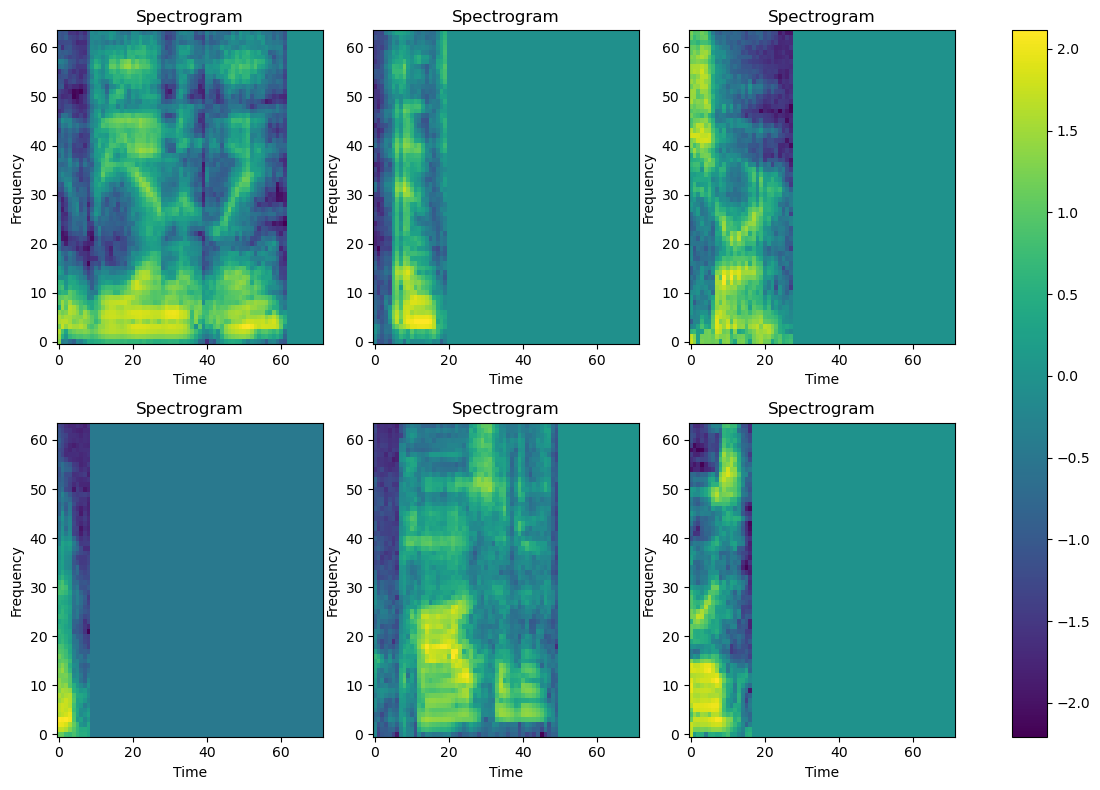

In [15]:
# Set the random seed for reproducibility
# random.seed(101)
# Generate six random indices
# random_indices = random.sample(range(len(xx_pad)), 6)
random_indices = list(range(6, 12))

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = xx_pad[idx]
    
    ax = axes[i]
    img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
    # ax.axvline(x=segment, color='red', linestyle='--')
    # ax.axvline(x=segment[1], color='red', linestyle='--')
    ax.set_title(f'Spectrogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.colorbar(img,ax=axes)
plt.show()

## Prepare model

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.BCELoss(reduction='none')
model_loss = MaskedLoss(recon_loss)

model = TheLearner(enc_size_list=ENC_SIZE_LIST, out_dim=mymap.token_num(), num_layers=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_str = str(model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)

In [19]:
# # initialize model weights
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.orthogonal_(m.weight)
#         m.bias.data.fill_(0.01)
#     if isinstance(m, nn.LSTM): 
#         for name, p in m.named_parameters():
#             if "weight" in name: 
#                 nn.init.orthogonal_(p)
#             elif "bias" in name: 
#                 nn.init.constant_(p, 0)

# model.apply(init_weights)

In [20]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [21]:
params

7911

### Load model if READ

In [22]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_name = "{}.pt".format(stop_epoch)
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

In [23]:
EPOCHS = 20
BASE = 0

In [26]:
def train(): 
    for epoch in range(BASE, BASE + EPOCHS):
        text_hist.print("Epoch {}".format(epoch))

        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        train_total = 0
        train_correct = 0
        for idx, (x, x_lens, y, y_lens) in enumerate(train_loader):
            # y_lens should be the same as x_lens
            optimizer.zero_grad()
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            x_hat = model(x, x_lens, x_mask)
            print(x_hat.shape, y.shape, x_mask.shape)

            loss = model_loss.get_loss(x_hat, y, x_mask)

            train_loss += loss.item()

            loss.backward()
            
            # # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # # 这个函数计算的是全局梯度范数
            # # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            # torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # # parameters: an iterable of Variables that will have gradients normalized
            # # max_norm: max norm of the gradients(阈值设定)
            # # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()
            pred = model.predict_on_output(x_hat)
            train_total += x_hat.size(0)
            train_correct += (pred == y).sum().item()

            if idx % 100 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

        train_losses.append(train_loss / train_num)
        train_accs.append(train_correct / train_total)
        text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}; Acc: {train_correct / train_total: .3f}※※※")

        last_model_name = "{}.pt".format(epoch)
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))


        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        valid_total = 0
        valid_correct = 0
        for idx, (x, x_lens, y, y_lens) in enumerate(valid_loader):
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            x_hat = model(x, x_lens, x_mask)

            loss = model_loss.get_loss(x_hat, y, x_mask)

            valid_loss += loss.item()

            pred = model.predict_on_output(x_hat)

            valid_total += x_hat.size(0)
            valid_correct += (pred == y).sum().item()

            if idx % 50 == 0:
                text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

        valid_losses.append(valid_loss / valid_num)
        valid_accs.append(valid_correct / valid_total)

        text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}; Acc: {valid_correct / valid_total}※※※")

In [27]:
if __name__ == "__main__": 
    train()

Epoch 0
torch.Size([256, 75, 39]) torch.Size([256, 75]) torch.Size([256, 75])


RuntimeError: The size of tensor a (39) must match the size of tensor b (75) at non-singleton dimension 2

In [36]:
### Save
train_losses.save()

valid_losses.save()

text_hist.save()

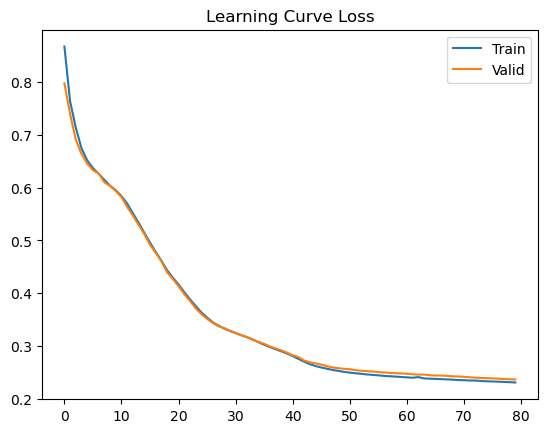

In [37]:
plt.plot(train_losses.get(), label='Train')
plt.plot(valid_losses.get(), label='Valid')
plt.title("Learning Curve Loss")
plt.legend()
plt.savefig(os.path.join(model_save_dir, "train.png"))

In [28]:
valid_losses.get()

[0.6973373221188057,
 0.5841517593802475,
 0.46406597117098364,
 0.44220086641427947,
 0.433954004107452,
 0.40526596729348346,
 0.4018787022044019,
 0.38418969802740144,
 0.3629494374845086,
 0.3243178616209728,
 0.2918721691864293,
 0.2824630453819182,
 0.27500432366278116,
 0.26278095855945494,
 0.2574981138473604,
 0.25056687578922365,
 0.25194803752550265,
 0.24937494498927418,
 0.2532334076922114,
 0.2538182386537878,
 0.26212876744386626,
 0.26849532272757554,
 0.2811444946905462,
 0.2902815022119662,
 0.30480065723744837,
 0.3194227662028336,
 0.33510804030953384,
 0.3481292710071657,
 0.35091513467998037,
 0.3703691254301769]

## Conclusion
This model should converge to loss around 0.49x. 